# An Overview of PyMKS

In this notebook I will be demonstrating the capabilites of PyMKS, a python library used for materials science and show how we can predict various effective and local properties of a given microstructure. Here I will mainly focus on the algorithms, but to learn more about the theory, you can check out my article on [Computational Materials Science](https://medium.com/@kiranamak/computational-materials-science-b23fdccc259).

In [1]:
import pymks

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Quantifying Microstructures Using 2-Point Statistics

First we generate two microstructures with different morphologies (given by grain size).
We group them together under X which is used to denote multiple microstructures.

In [2]:
from pymks.datasets import make_microstructure
import numpy as np

X_1 = make_microstructure(n_samples=1, grain_size=(25, 25))
X_2 = make_microstructure(n_samples=1, grain_size=(95, 15))

X = np.concatenate((X_1, X_2))

We can visualize the generated microstructues.

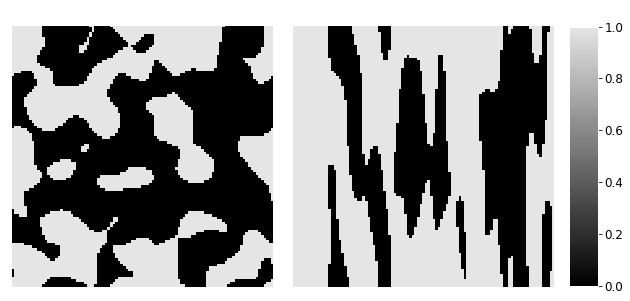

In [3]:
from pymks.tools import draw_microstructures

draw_microstructures(X)

To compute the 2-point statistics, we 
1. use the `PrimitiveBasis` function to discretize the microstructure
2. call `correlate` to determine the auto and cross-correlations for the microstructure

In [4]:
from pymks import PrimitiveBasis
from pymks.stats import correlate


p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
X_corr = correlate(X, p_basis, periodic_axes=[0, 1])

We print the two autocorrelations and the cross-correlation for each microstructure.

(101, 101, 3)


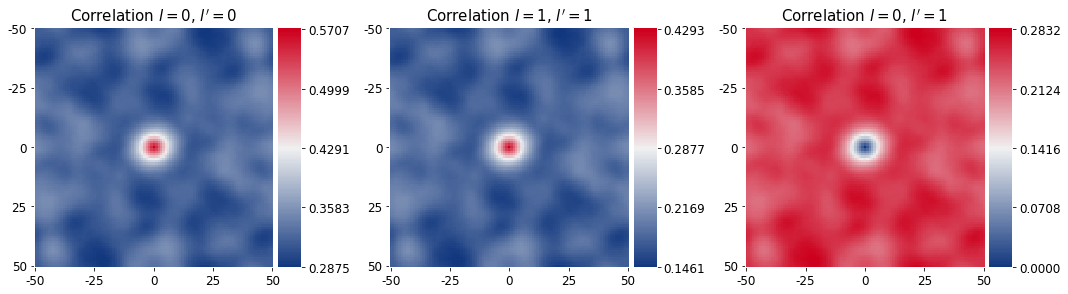

In [5]:
from pymks.tools import draw_correlations

print(X_corr[0].shape)

draw_correlations(X_corr[0])

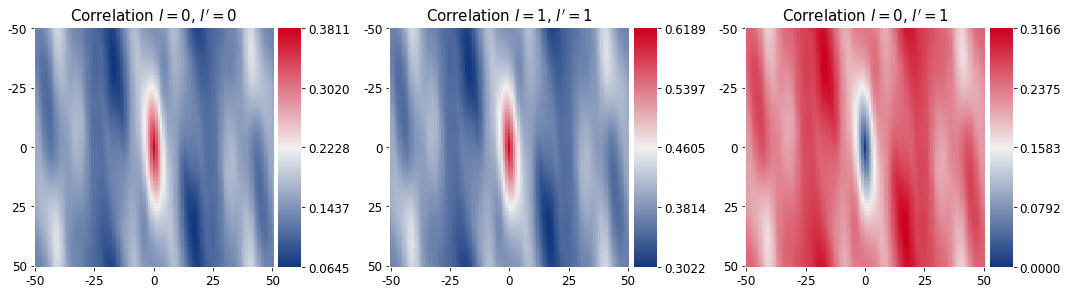

In [6]:
draw_correlations(X_corr[1])

# Predicting Homogenized Properties

Now we will attempt to predict the effective stiffness for given microstructures.

To begin we generate 200 random instances of 3 different types of microstructures. X_train is the array of microstructures and y_train their corresponding effective stiffness.

In [7]:
from pymks.datasets import make_elastic_stress_random


grain_size = [(47, 6), (4, 49), (14, 14)]
n_samples = [200, 200, 200]

X_train, y_train = make_elastic_stress_random(n_samples=n_samples, size=(51, 51), grain_size=grain_size, seed=0)


We create a visual representation below.

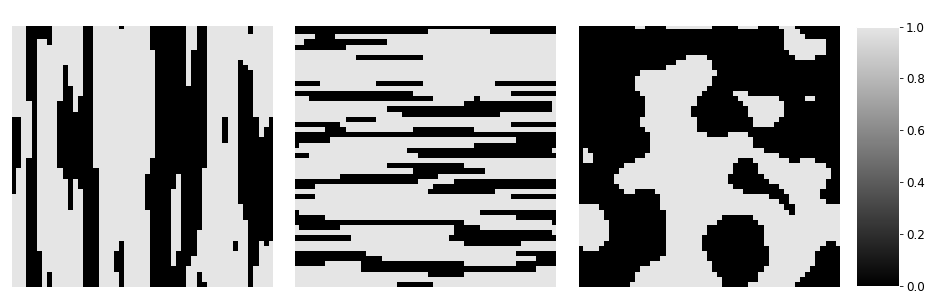

In [8]:
draw_microstructures(X_train[::200])

As before, since `MKSHomogeinzationModel` uses 2-point statistics, we must discretize using `PrimitiveBasis`. `MKSHomogenizationModel` also takes in the correlations we want to base the model off of.

In [9]:
from pymks import MKSHomogenizationModel


p_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
homogenize_model = MKSHomogenizationModel(basis=p_basis, periodic_axes=[0, 1], correlations=[(0, 0), (1, 1), (0, 1)])


We then fit the model with the generated data.

In [10]:
homogenize_model.fit(X_train, y_train)

In theory now our model should be trained. To determine how accurate it is, we will generate new data to test it with.

In [11]:
n_samples = [10, 10, 10]
X_test, y_test = make_elastic_stress_random(n_samples=n_samples, size=(51, 51), grain_size=grain_size, seed=100)

Now we use the model to predict the effective stiffness of the newly created data.

In [12]:
y_pred = homogenize_model.predict(X_test)

The `MKSHomogenizationModel` creates low dimensional representations of the microstructures (PCA) and uses regression to be able to predict effective properties. The graph below shows the low dimensional representation.

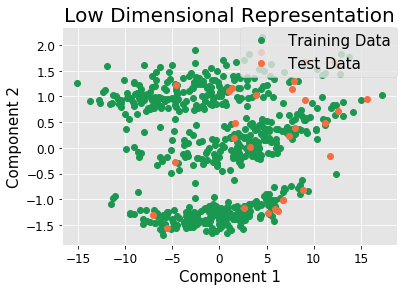

In [13]:
from pymks.tools import draw_components_scatter


draw_components_scatter([homogenize_model.reduced_fit_data[:,:2],
                         homogenize_model.reduced_predict_data[:,:2]], 
                        ['Training Data', 'Test Data'])

Now we can determine how accurate our model was by looking at a goodness of fit plot. As you can see, the model was highly accurate for both the training data and the testing data.

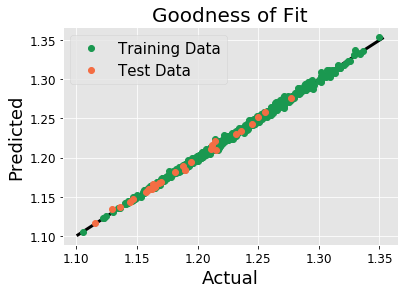

In [14]:
from pymks.tools import draw_goodness_of_fit


fit_data = np.array([y_train, homogenize_model.predict(X_train)])
pred_data = np.array([y_test, y_pred])

draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Test Data'])

# Predicting Local Properties

Now we will predict localize properties using `MKSLocalizationModel`. In this example we will use the local strain field of a microstructure.

We begin by generating data using the function `make_elastic_FE-strain_delta()`. Again, X_delta is the microstructure and y_delta is the coresponding local strain field.

In [15]:
from pymks.datasets import make_elastic_FE_strain_delta


X_delta, y_delta = make_elastic_FE_strain_delta()

We must discretize the microstructure again using `PrimitiveBasis`.

In [16]:
from pymks import MKSLocalizationModel


p_basis = PrimitiveBasis(n_states=2)
localize_model = MKSLocalizationModel(basis=p_basis)

Then we fit our model with the initial generated data.

In [17]:
localize_model.fit(X_delta, y_delta)

As before we will test against new data. We create a new microstructure X_test with local strain field y_test.

In [18]:
from pymks.datasets import make_elastic_FE_strain_random


X_test, y_test = make_elastic_FE_strain_random()

Let's look at it visually.

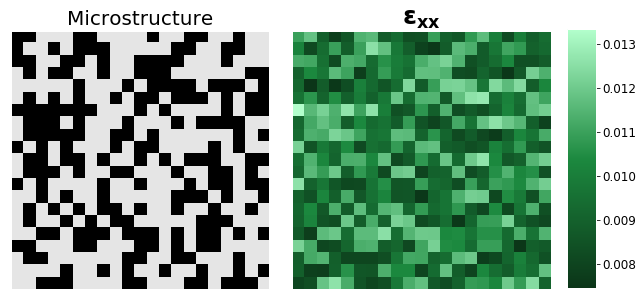

In [19]:
from pymks.tools import draw_microstructure_strain


draw_microstructure_strain(X_test[0], y_test[0])

We use our model to predict the local strain field of the test data and then visually compare side by side. The two strain fields are highly similar indicating that our model was successfully able to predict local properites.

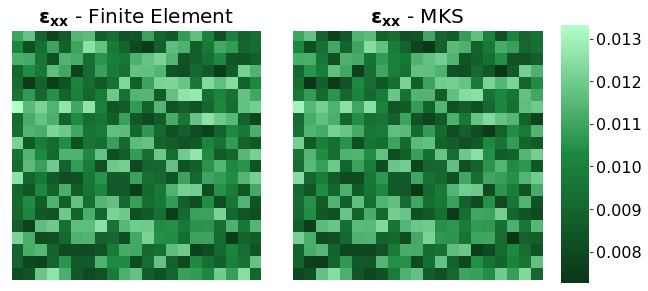

In [20]:
from pymks.tools import draw_strains_compare

y_pred = localize_model.predict(X_test)
draw_strains_compare(y_test[0], y_pred[0])

## To recap, we were able to:
- Generate various microstructures with different morphologies
- Compute 2-point statistics on them
- Use homogenization and PCA to predict the effective properties of microstructures (in this case stress)
- Use a localization model to predict local properites of a microstructure (in this example local strain field).